## Задачи, поставленные продакт-менеджером
1) Сколько пользователей, которые совершили покупку только один раз?

2) Сколько заказов в месяц в среднем не доставляется? Детализация причин.

3) По каждому товару определить, в какой день недели товар чаще всего покупается.

4) Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Учесть в метрике, что в месяце мб нецелое количество недель

5) Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц

6) Качественно оценить аудиторию. Построить RFM-сегментацию пользователей (в python). Метрики кластеризации:
- R - время от последней покупки пользователя до текущей даты,
- F - суммарное количество покупок у пользователя за всё время, 
- M - сумма покупок за всё время.

Подробно описать процесс создания кластеров\
Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров

-----------------

## Решение

In [1]:
# Загрузка модулей
import pandas as pd
import requests
from urllib.parse import urlencode
from operator import attrgetter
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import rfm

In [2]:
# Настройка графиков
sns.set(
    font_scale=1.3, 
    style='whitegrid', 
    rc={'figure.figsize': (10, 6)}
)

### Данные

#### Таблица с уникальными идентификаторами пользователей (olist_customers_datase.csv) - customers_df

In [3]:
# загрузка из папки
path_to_file = 'olist_customers_dataset.csv'
customers_df = pd.read_csv(path_to_file)
customers_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [4]:
# использование ссылки на файл
ya_prefix = 'https://getfile.dokpub.com/yandex/get/'
file_link = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
customers_df = pd.read_csv(ya_prefix + file_link)
customers_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [5]:
# использование api Ядиска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
customers_df = pd.read_csv(download_url)
customers_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [6]:
customers_df.shape

(99441, 5)

- customer_id — позаказный идентификатор пользователя
- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

#### Таблица заказов (olist_orders_dataset.csv) - orders_df

In [7]:
# загрузка из папки
path_to_file = 'olist_orders_dataset.csv'
orders_df = pd.read_csv(path_to_file)
orders_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [8]:
orders_df.shape

(99441, 8)

- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа:
  - created —  создан
  - approved —  подтверждён
  - invoiced —  выставлен счёт
  - processing —  в процессе сборки заказа
  - shipped —  отгружен со склада
  - delivered —  доставлен пользователю
  - unavailable —  недоступен
  - canceled —  отменён
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

#### Товарные позиции, входящие в заказы (olist_order_items_dataset.csv) - items_df

In [9]:
# загрузка из папки
path_to_file = 'olist_order_items_dataset.csv'
items_df = pd.read_csv(path_to_file)
items_df.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [10]:
items_df.shape

(112650, 7)

- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

----------------------------

### Преобразование типов данных

**customers_df**

In [11]:
customers_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [12]:
customers_df.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

**orders_df**

In [13]:
orders_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [14]:
orders_df.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [15]:
orders_df.order_purchase_timestamp = pd.to_datetime(orders_df.order_purchase_timestamp)
orders_df.order_purchase_timestamp[0]

Timestamp('2017-10-02 10:56:33')

In [16]:
orders_df.order_approved_at = pd.to_datetime(orders_df.order_approved_at)
orders_df.order_delivered_carrier_date = pd.to_datetime(orders_df.order_delivered_carrier_date)
orders_df.order_delivered_customer_date = pd.to_datetime(orders_df.order_delivered_customer_date)
orders_df.order_estimated_delivery_date = pd.to_datetime(orders_df.order_estimated_delivery_date)

In [17]:
orders_df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

**items_df**

In [18]:
items_df.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [19]:
items_df.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [20]:
items_df.shipping_limit_date = pd.to_datetime(items_df.shipping_limit_date)
items_df.shipping_limit_date[0]

Timestamp('2017-09-19 09:45:35')

In [21]:
items_df.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

#### Проверка на корректность данных

In [22]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [23]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [24]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


------------------------------------

### 0) Предварительное исследование данных. Что должно считаться покупкой? Обоснование

#### Изучение orders_df и items_df

In [25]:
# Таблица с заказами и товарными единицами
orders_items_df = pd.merge(left=orders_df, right=items_df, how='left', on='order_id')
orders_items_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value'],
      dtype='object')

In [26]:
# Изменение порядка столбцов для удобства
orders_items_df = orders_items_df[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
                                   'order_approved_at', 'shipping_limit_date', 'order_delivered_carrier_date',
                                   'order_delivered_customer_date', 'order_estimated_delivery_date',
                                   'order_item_id', 'product_id', 'seller_id',
                                   'price', 'freight_value']]
orders_items_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-06 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-30 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-13 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22


In [27]:
orders_items_df.shape

(113425, 14)

In [28]:
orders_df.shape

(99441, 8)

=> В некоторых заказах несколько товарных позиций

- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- price —  цена за единицу товара
- freight_value —  вес товара

In [29]:
orders_df.order_id.nunique()

99441

В df с заказами все id заказов уникальны

_Частотность статусов заказов_

In [30]:
orders_df.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

delivered - наиболее частый (можно назвать покупкой?)

- delivered —  доставлен пользователю
- shipped —  отгружен со склада
- canceled —  отменён
- unavailable —  недоступен
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- created —  создан
- approved —  подтверждён

**Анализ статусов заказов**

_shipped_ - заказ оплачен, передан в логистическую службу

In [31]:
orders_items_df.query('order_status == "shipped"').head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
46,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-13 04:30:33,2018-06-05 14:32:00,NaT,2018-06-28,1.0,c50ca07e9e4db9ea5011f06802c0aea0,e9779976487b77c6d4ac45f75ec7afe9,14.49,7.87
185,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-18 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,1.0,ee0c1cf2fbeae95205b4aa506f1469f0,cc419e0650a3c5ba77189a1882b7556a,53.99,15.13
193,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-17 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,1.0,ba4bfbf74dbe7ab37e263b9326da0523,f8db351d8c4c4c22c6835c19a46f01b0,36.90,26.89
268,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-23 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,1.0,62bf07cdb14270c48cf42ca0312986aa,04e38a233f726ef161074ab1c9b0399a,199.90,40.33
340,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03,1.0,6026308f343d15d492324e7e35ba5685,966cb4760537b1404caedd472cc610a5,844.00,21.01


_unavailable_ - заказ оплачен, НЕ передан в логистическую службу (+ почему-то нет ограничения на дату передачи в логистическую службу)

In [32]:
orders_items_df.query('order_status == "unavailable"').head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
306,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,NaT,2017-12-05,NaN,NaN,NaN,NaN,NaN
671,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,NaT,2018-02-16,NaN,NaN,NaN,NaN,NaN
791,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,NaT,2017-09-05,NaN,NaN,NaN,NaN,NaN
850,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,NaT,2018-02-06,NaN,NaN,NaN,NaN,NaN
1326,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,NaT,2017-10-27,NaN,NaN,NaN,NaN,NaN


In [33]:
orders_df.query('order_status == "unavailable"').order_delivered_carrier_date.nunique()

0

_invoiced_ - заказ оплачен, НЕ передан в логистическую службу

In [34]:
orders_items_df.query('order_status == "invoiced"').head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,2017-04-19 13:25:17,NaT,NaT,2017-05-09,1.0,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,49.90,16.05
118,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,2018-08-13 06:15:14,NaT,NaT,2018-08-21,1.0,1522589c64efd46731d3522568e5bc83,28405831a29823802aa22c084cfd0649,35.00,15.35
515,38b7efdf33dd5561f4f5d4f6e07b0414,021e84751ba0ead75b6d314a6ead88d9,invoiced,2017-08-01 18:17:41,2017-08-01 18:32:30,2017-08-10 18:32:30,NaT,NaT,2017-08-28,1.0,8988d11aace15e3c9e25763c6d87dcf5,891071be6ba827b591264c90c2ae8a63,29.99,14.10
2083,51b0dccc8596ce37a930dff2d63a10a2,31bf1057b00f14804278590bbac18b1b,invoiced,2017-05-05 22:34:48,2017-05-05 22:45:12,2017-05-11 22:45:12,NaT,NaT,2017-06-06,1.0,bace90a7338e9d31371ad47811cf4c7d,1a3df491d1c4f1589fc2b934ada68bf2,99.90,17.78
2407,5504eaa5a86eb25fa666cf2e6b96c701,a30be38e1ed0ffb39b318bf1d15e98d9,invoiced,2017-11-29 08:33:06,2017-11-29 08:56:23,2017-12-05 08:56:23,NaT,NaT,2017-12-20,1.0,4a3b0111d9c112251e4732b44d1d118b,3a734b715d333a2588a3d54a0c9b8746,117.00,14.57


In [35]:
orders_df.query('order_status == "invoiced"').order_delivered_carrier_date.nunique()

0

_processing_ - заказ оплачен, собирается, ещё не передан в логистическую службу

In [36]:
orders_items_df.query('order_status == "processing"').head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
148,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,2017-09-20 14:30:09,NaT,NaT,2017-10-03,1.0,61d52f4882421048afd530db53d6f230,fa74b2f3287d296e9fbd2cc80f2d1cf1,125.9,12.38
369,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,2016-10-21 16:24:45,NaT,NaT,2016-12-09,1.0,ca17b18b38db6e0d2c33d362322f2a06,4be2e7f96b4fd749d52dff41f80e39dd,267.0,32.84
854,6a6c7d523fd59eb5bbefc007331af717,d954782ec6c0e911292c8a80757ef28d,processing,2017-11-24 20:09:33,2017-11-24 23:15:15,2017-12-05 23:15:15,NaT,NaT,2017-12-20,1.0,73a6530caef9511c04711d12dcef551c,4e42581f08e8cfc7c090f930bac4552a,129.0,47.61
1360,745e1d4a7f8c4b548881788d4113bb1d,7198d7088442e4ddfe553353d8ddc957,processing,2017-11-17 06:34:36,2017-11-18 02:15:40,2017-11-24 02:15:40,NaT,NaT,2017-12-12,1.0,4ddea479f39c2acfbde72ff8ddcec134,ec21206b7894c503788a684a7bc822a6,32.9,15.10
1731,1d52ba7197c7acebbb4f826f6585536f,c9c7fe860d602373a9e93f8bfe9d877a,processing,2017-02-13 18:32:55,2017-02-13 18:43:55,2017-03-04 17:32:55,NaT,NaT,2017-04-04,1.0,4c35791f944cf1550e8ae288b3f9e258,79ee721b6f766066a80264402548d359,269.0,17.09


_approved_ - заказ оплачен, НЕ передан в логистическую службу

In [37]:
orders_items_df.query('order_status == "approved"').head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
51158,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,2017-02-10 20:18:17,NaT,NaT,2017-03-01,1.0,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,19.85,10.96
51159,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,2017-02-10 20:18:17,NaT,NaT,2017-03-01,2.0,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,19.85,10.96
100774,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,2017-05-08 20:32:41,NaT,NaT,2017-05-22,1.0,c4a1c4638fa9e2e4861d141d6e0259e7,5444b12c82f21c923f2639ebc722c1ea,169.90,9.56


Заказы, для которых не указано время оплаты (все отменённые?)

In [38]:
orders_df.order_approved_at.isna().sum()

160

Статусы неопаченных заказов

In [39]:
orders_df.loc[orders_df.order_approved_at.isna()].order_status.value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

- canceled - не оплачен и отменён
- delivered - похоже на аномалию!
- created - заказ только сформирован пользователем, не успел дойти до оплаты

#### Рассмотрение предполагаемой аномалии с доставкой заказа без указания времени оплаты

In [40]:
orders_df.query('order_status == "delivered" and order_approved_at == "NaT"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Закономерности:
- имеется дата передачи заказа в логистическую службу => похоже, заказ действительно был совершён
- заказ доставлен ощутимо раньше предполагаемого срока

_Среднее время опережения сроков доставки по данной таблице_

In [41]:
(orders_df.query('order_status == "delivered" and order_approved_at == "NaT"').order_estimated_delivery_date - orders_df.query('order_status == "delivered" and order_approved_at == "NaT"').order_delivered_customer_date).dt.days.mean()

21.142857142857142

_Среднее время опережения сроков доставки по df_

In [42]:
(orders_df.query('order_status == "delivered"').order_estimated_delivery_date - orders_df.query('order_status == "delivered"').order_delivered_customer_date).dt.days.mean()

10.875888877371203

Действительно, время опережения сроков доставки превышает среднее, но разница не слишком значительна

_Возможно, отсутствие даты оплаты - следствие какой-то акции на определённые товары?_

In [43]:
orders_items_df.query('order_status == "delivered" and order_approved_at == "NaT"').sort_values('product_id')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
44820,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-25 10:04:19,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,1.0,02a79d79e818ad0be36cfc843a6af7ad,cb3dd9ce66268c7a3ca7241ac70ab58c,28.99,10.96
6009,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-22 13:40:00,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,1.0,0e20a07ca1714df21f9b07ca3bf7c682,4e7c18b98d84e05cbae3ff0ff03846c2,309.90,39.11
18860,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-22 11:45:31,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,1.0,2c2b6a28924791234bd386bddb17512e,a4b6b9b992b46e9ef863637af96e04bc,379.00,17.86
70281,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-21 16:21:55,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,1.0,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,135.00,19.23
21661,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 12:29:47,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,1.0,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,49.99,15.53
30541,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-23 12:48:08,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,1.0,5ab02ca028398131a5ae91401eb49788,80e6699fe29150b372a0c8a1ebf7dcc8,39.99,14.52
71794,51eb2eebd5d76a24625b31c33dd41449,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaT,2017-02-28 14:52:27,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,1.0,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,59.90,17.16
77167,88083e8f64d95b932164187484d90212,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaT,2017-02-22 21:49:19,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21,1.0,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,49.00,14.52
77168,88083e8f64d95b932164187484d90212,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaT,2017-02-22 21:49:19,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21,2.0,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,49.00,14.52
55152,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-29 22:26:59,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,1.0,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,45.90,14.52


Интересно, что в некоторых записях имеется несоблюдение ограничения на дату поставки в логистическую службу


Цена у товаров есть, причём немаленькая (слабо верится, что возможно сбить её до нуля акцией)

Заключение по аномалии:
- За исключением преждевременности доставки данные выглядят достаточно адекватно, так что больше похоже на сбой в системе записи времени подтверждения оплаты.  
- В версию оплаты заказа после доставки верится слабо - в силу малого числа подобных записей

В любом случае число подобных заказов мало => аномалия не принесёт серьёзных последствий даже в случае неправильного предположения об их природе

#### Итоги
Предполагается, что схема последовательности обработки заказа выглядит следующим образом (статус заказа):
1. created - отдельные товарные позиции помещены пользователем в корзину
2. invoiced / approved  - заказ оплачен, данные передаются для сбора товарных позиций
3. processing - сборка заказа
4. shipped - собранный заказ в пути к пользователю
5. delivered - пользователь получил заказ  
  
При этом возможны проблемы следующего рода:  
- unavailable - возникли проблемы со сборкой заказа (мб товар закончился)  
- canceled - отмена заказа

Под покупкой будем подразумевать успешную покупку, тк только в этом случае магазин получает прибыль. Признаком успешной покупки считается то, что пользователь получил заказ (и при этом его не отменил) - статус заказа delivered.\
В зависимости от контекста под единицей покупки можно понимать заказ / товарную позицию\
Момент покупки - момент совершения транзакции (её подтверждения)\
**Покупка - успешный (статус delivered) заказ (товарной позиции)**

-------------

### 1) Сколько пользователей, которые совершили покупку только один раз?

In [44]:
orders_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [45]:
orders_df.shape

(99441, 8)

In [46]:
orders_df.customer_id.nunique()

99441

=> все customer_id уникальные  
Видимо, это поле используется для сокрытия информации о реальном пользователе  
Реальный id пользователя можно получить из таблицы customers_df

In [47]:
orders_customers_df = pd.merge(left=orders_df, right=customers_df, how='left', on='customer_id')
orders_customers_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


In [48]:
orders_customers_df.shape

(99441, 12)

In [49]:
orders_customers_df.customer_unique_id.isna().sum()

0

=> соответствие нашлось для каждого customer_id

Под единицей покупки полагается заказ (т.к. продакт менеджера скорее всего интересуют пользователи, воспользовавшиеся магазином лишь раз, нежели пользователи, которые приобрели единственный товар)

In [50]:
sum(orders_customers_df.query('order_status == "delivered"').customer_unique_id.value_counts() == 1)

90557

#### Ответ: всего 90557 пользователей, совершивших единственную покупку

Всего пользователей

In [51]:
orders_customers_df.customer_unique_id.nunique()

96096

=> пользователей с единственной покупкой достаточно много

-------------------------

### 2) Сколько заказов в месяц в среднем не доставляется? Детализация причин

#### Подсчёт числа заказов по месяцам

Месяц используем тот, в который был создан заказ  
_Заказов НЕ доставлено_

In [52]:
orders_status_df = pd.DataFrame()
orders_status_df['not_delivered'] = (
    orders_df.set_index('order_purchase_timestamp')
    .query('order_status != "delivered"')
    .resample(rule='M').order_id.count()
)

In [53]:
orders_status_df.head()

,not_delivered
order_purchase_timestamp,
2016-09-30,3
2016-10-31,59
2016-11-30,0
2016-12-31,0
2017-01-31,50


_Заказов доставлено_

In [54]:
orders_status_df['delivered'] = (
    orders_df.set_index('order_purchase_timestamp')
    .query('order_status == "delivered"')
    .resample(rule='M').order_id.count()
)

In [55]:
orders_status_df.head()

,not_delivered,delivered
order_purchase_timestamp,,
2016-09-30,3,1.0
2016-10-31,59,265.0
2016-11-30,0,0.0
2016-12-31,0,1.0
2017-01-31,50,750.0


Всего заказов на основании доставленных и недоставленных

In [56]:
orders_status_df['sum'] = orders_status_df.not_delivered + orders_status_df.delivered

In [57]:
orders_status_df.head()

,not_delivered,delivered,sum
order_purchase_timestamp,,,
2016-09-30,3,1.0,4.0
2016-10-31,59,265.0,324.0
2016-11-30,0,0.0,0.0
2016-12-31,0,1.0,1.0
2017-01-31,50,750.0,800.0


Всего заказов по исходному df

In [58]:
orders_status_df['all'] = (
    orders_df.set_index('order_purchase_timestamp')
    .resample(rule='M').order_id.count()
)

In [59]:
orders_status_df.head()

,not_delivered,delivered,sum,all
order_purchase_timestamp,,,,
2016-09-30,3,1.0,4.0,4
2016-10-31,59,265.0,324.0,324
2016-11-30,0,0.0,0.0,0
2016-12-31,0,1.0,1.0,1
2017-01-31,50,750.0,800.0,800


Разница между получившимся количеством заказов и их исходным значением

In [60]:
(orders_status_df['sum'] - orders_status_df['all']).sum()

0.0

=> расчёт корректен

_График по количеству недоставленных товаров_

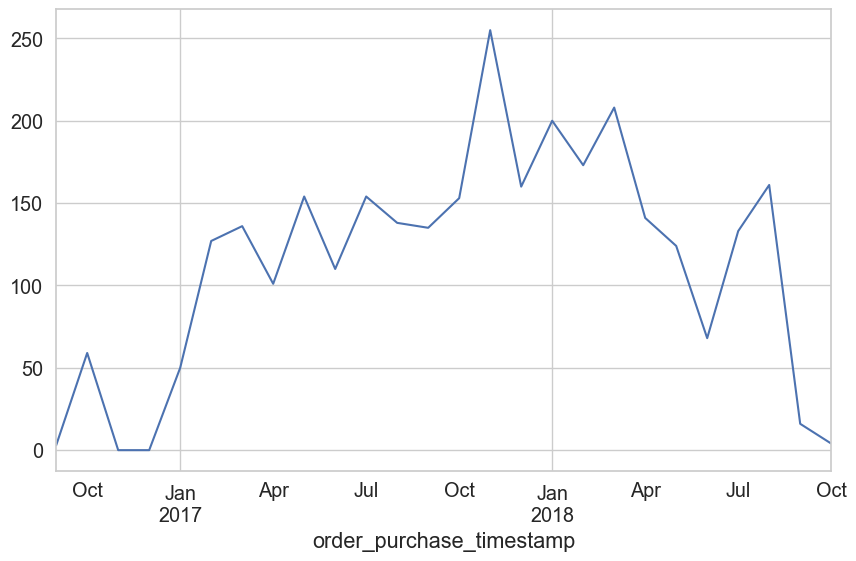

In [61]:
orders_status_df.not_delivered.plot();

При этом стоит учитывать, что заказ мб не доставлен по причине того, что он ещё готовится/доставляется. Скорее всего это не то, что интересует продакт-менеджера

**Среднее количество недоставленных заказов в месяц по статусам**

In [62]:
orders_df.order_purchase_timestamp.dt.to_period('M').dt.to_timestamp()

0       2017-10-01
1       2018-07-01
2       2018-08-01
3       2017-11-01
4       2018-02-01
           ...    
99436   2017-03-01
99437   2018-02-01
99438   2017-08-01
99439   2018-01-01
99440   2018-03-01
Name: order_purchase_timestamp, Length: 99441, dtype: datetime64[ns]

In [63]:
order_status_stats = (
orders_df
    .assign(purchase_month = orders_df.order_purchase_timestamp.dt.to_period('M').dt.to_timestamp())
    .query('order_status != "delivered"')
    # Категории для учёта градаций order_status, которые могут отсутствовать для текущего месяца
    .astype({'order_status': 'category'})  
    .groupby(['purchase_month', 'order_status'], as_index=False).order_id.count()
    .rename(columns={'order_id': 'order_count'})
)
order_status_stats.order_count.fillna(0, inplace=True)
order_status_stats = (
    order_status_stats
    .groupby('order_status', as_index=False).order_count.mean()
    .round(1)
    .sort_values('order_count', ascending=False)
)
order_status_stats

,order_status,order_count
5,shipped,46.1
1,canceled,26.0
6,unavailable,25.4
3,invoiced,13.1
4,processing,12.5
2,created,0.2
0,approved,0.1


По статусам, которые скорее всего интересуют продакт-менеджера

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [64]:
list(order_status_stats.order_status.unique())

['shipped',
 'canceled',
 'unavailable',
 'invoiced',
 'processing',
 'created',
 'approved']

In [65]:
interest_statuses = ['canceled', 'unavailable']

In [66]:
order_status_stats.query('order_status in @interest_statuses')

,order_status,order_count
1,canceled,26.0
6,unavailable,25.4


**Среднее число недоставленных заказов в месяц**

In [67]:
order_status_stats.query('order_status in @interest_statuses').order_count.sum()

51.4

#### Выводы:
- в месяц в среднем не доставляется ~51 заказ
- наиболее частая причина недоставки груза в месяц заказа - отмена заказа

---------------------------------

### 3) По каждому товару определить, в какой день недели товар чаще всего покупается.

df с детализацией заказов по товарам

In [68]:
orders_items_df = pd.merge(left=orders_df, right=items_df, on='order_id')
orders_items_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


In [69]:
orders_items_df.shape

(112650, 14)

Успешные заказы

In [70]:
# sx - success
orders_items_sx_df = orders_items_df[orders_items_df.order_status == 'delivered']
orders_items_sx_df.shape

(110197, 14)

Под датой покупки понимается дата совершения транзакции (=> она должна быть)

In [71]:
orders_items_sx_df = orders_items_sx_df.query('order_approved_at != "NaT"')
orders_items_sx_df.shape

(110182, 14)

In [72]:
# Проверка
orders_items_sx_df.order_approved_at.isna().sum()

0

Добавляем поле с днём недели подтверждения оплаты

In [73]:
orders_items_sx_df['purchase_weekday'] = orders_items_sx_df.order_approved_at.dt.day_name()
orders_items_sx_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,purchase_weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday


In [74]:
# Сколько уникальных товаров должно получится при определении их излюбленного дня покупки
orders_items_sx_df.product_id.nunique()

32213

#### Расчёт самых популярных дней недели для покупки каждого товара

Частота покупок товаров по дням

In [75]:
# Частота покупок продуктов по дням недели
product_days_df = (
    orders_items_sx_df
    .groupby('product_id').purchase_weekday.value_counts()
    .to_frame().rename(columns={'purchase_weekday': 'freq'}).reset_index()
)
# Упорядочивание дней недели
product_days_df.purchase_weekday = pd.Categorical(
    product_days_df.purchase_weekday,
    categories=['Monday', 
                'Tuesday', 
                'Wednesday', 
                'Thursday', 
                'Friday', 
                'Saturday',
                'Sunday']
)
# Наибольшая частота покупок продукта
max_freq = (
    product_days_df
    .groupby('product_id', as_index=False).freq.max()
    .rename(columns={'freq': 'max_freq'})
)
product_days_df = product_days_df.merge(max_freq, on='product_id')
# Оставить для товаров лишь дни недели с наибольшимм количеством товаров
product_days_df.query('freq == max_freq', inplace=True)
# Обернуть дни недели для товара в список
product_days_view_df = (
    product_days_df
    .groupby('product_id')
    .purchase_weekday.apply(list)
    .to_frame()
    .merge(max_freq, on='product_id')
)[['product_id', 'max_freq', 'purchase_weekday']]
    
product_days_view_df  

,product_id,max_freq,purchase_weekday
0,00066f42aeeb9f3007548bb9d3f33c38,1,[Sunday]
1,00088930e925c41fd95ebfe695fd2655,1,[Tuesday]
2,0009406fd7479715e4bef61dd91f2462,1,[Friday]
3,000b8f95fcb9e0096488278317764d19,1,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,1,[Tuesday]
...,...,...,...
32208,fff6177642830a9a94a0f2cba5e476d1,1,"[Monday, Saturday]"
32209,fff81cc3158d2725c0655ab9ba0f712c,1,[Monday]
32210,fff9553ac224cec9d15d49f5a263411f,1,[Saturday]
32211,fffdb2d0ec8d6a61f0a0a0db3f25b441,3,[Tuesday]


Топ дней для покупки товаров

In [76]:
product_days_df.purchase_weekday.value_counts().sort_values(ascending=False)

Tuesday      8141
Wednesday    6574
Thursday     6517
Friday       6122
Monday       5482
Saturday     5066
Sunday       3715
Name: purchase_weekday, dtype: int64

Интересно, что меньше всего покупок производится на выходных

-----------------------

### 4) Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Учесть в метрике, что в месяце мб нецелое количество недель
Расчёт производится относительно месяцев, когда пользователь активен

In [77]:
orders_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

Единица покупки - заказ

_Успешные покупки_

In [78]:
customers_orders_sx_df = (
    orders_customers_df
    .query('order_status == "delivered"')
)
customers_orders_sx_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [79]:
customers_orders_sx_df.shape

(96478, 12)

In [80]:
orders_customers_df.shape

(99441, 12)

_Cтолбец с месяцем покупки_

In [81]:
customers_orders_sx_df = (
    customers_orders_sx_df
    .assign(order_approved_at_month=
            customers_orders_sx_df['order_approved_at']
            .dt.to_period('M')
           )
)
customers_orders_sx_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_approved_at_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02


Количество покупок для каждого пользователя по месяцам

In [82]:
customer_orders_amount_df = (
    customers_orders_sx_df
    .groupby(['customer_unique_id', 'order_approved_at_month'], as_index=False)
    .order_id.count()
    .rename(columns={'order_approved_at_month': 'month',
                     'order_id': 'orders_amount'
                    })
)

customer_orders_amount_df

,customer_unique_id,month,orders_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1
...,...,...,...
95171,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1
95172,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1
95173,ffff371b4d645b6ecea244b27531430a,2017-02,1
95174,ffff5962728ec6157033ef9805bacc48,2018-05,1


Сколько недель в каждом месяце

In [83]:
# Имеющиеся месяцы
months = pd.DataFrame(
    {'month': customer_orders_amount_df.month.unique()}
).sort_values('month').reset_index(drop=True)
# Количество дней в каждом месяце
months['days_in_month'] = months.month.dt.days_in_month
# Корректировка для первого и последнего месяца
first_month_correction = (
    int(orders_df.order_purchase_timestamp.dt.date.min().strftime('%d'))
)
last_month_correction = (
    int(orders_df.order_purchase_timestamp.dt.date.max().strftime('%d'))
)
months.loc[0, 'days_in_month'] -= (first_month_correction - 1)
months.loc[len(months)-1, 'days_in_month'] = last_month_correction
# Недель в каждом месяце
months = (
    months
    .assign(weeks_in_month=months.days_in_month/7)
)[['month', 'weeks_in_month']]
months

,month,weeks_in_month
0,2016-09,3.857143
1,2016-10,4.428571
2,2016-12,4.428571
3,2017-01,4.428571
4,2017-02,4.000000
5,2017-03,4.428571
6,2017-04,4.285714
7,2017-05,4.428571
8,2017-06,4.285714
9,2017-07,4.428571


**Среднее число покупок в неделю (в месяцах, когда пользователь активен) для каждого пользователя**

In [84]:
# Сколько недель в каждом месяце, когда пользователь был активен
customer_orders_stats_df = customer_orders_amount_df.merge(months, how='left', on='month')
# Среднее число покупок в неделю месяца для пользователя
customer_orders_stats_df['av_week_orders'] = (
    customer_orders_stats_df.orders_amount
    / customer_orders_stats_df.weeks_in_month
)
# Среднее число покупок в неделю (для месяцев активности) для пользователя
customer_week_orders_df = (
    customer_orders_stats_df
    .groupby('customer_unique_id', as_index=False)
    .av_week_orders.mean()
)

customer_week_orders_df

,customer_unique_id,av_week_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,0.225806
4,0004aac84e0df4da2b147fca70cf8255,0.233333
...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,0.233333
93341,fffea47cd6d3cc0a88bd621562a9d061,0.225806
93342,ffff371b4d645b6ecea244b27531430a,0.250000
93343,ffff5962728ec6157033ef9805bacc48,0.225806


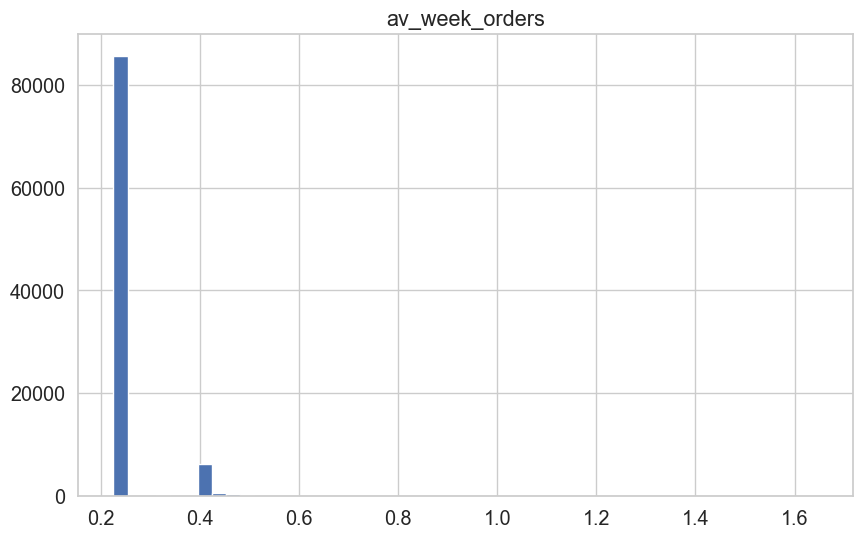

In [85]:
customer_week_orders_df.hist(bins=50);

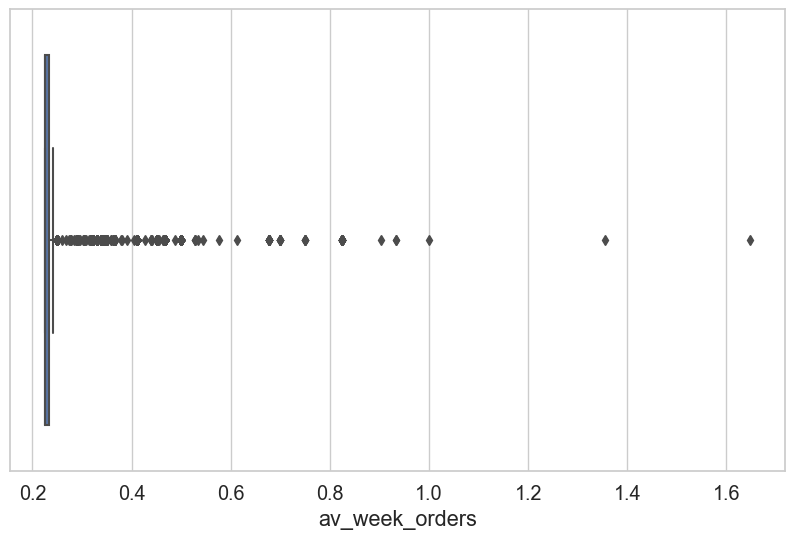

In [86]:
sns.boxplot(data=customer_week_orders_df, x='av_week_orders');

Как можно заметить, в неделю (активный месяц) пользователи в среднем совершают менее одной покупки

------------------------------

### 5) Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц

#### Основные параметры для проведения когортного анализа
- Метрика - retention (% пользователей, вернувшихся через заданное время)
- Признак формирования когорты - уникальные пользователи, совершившие первую покупку в определённый месяц (сегмент пользователей)
- Размер когорты - 1 мес
- Отчётный период - январь-декабрь 2017 (единственный год, где в полном объёме доступны данные по заданным месяцам)

*По полученному шаблону можно будет построить когортный анализ для любого временного промежутка

In [87]:
customers_df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [88]:
orders_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [89]:
orders_df.shape

(99441, 8)

Единица покупки - заказ

_ДФ с покупками пользователей_

In [90]:
customers_orders_df = pd.merge(
    left=customers_df[['customer_id', 'customer_unique_id']],
    right=orders_df[['customer_id', 'order_id', 'order_status', 'order_approved_at']],
    on='customer_id'
)
customers_orders_df.head(3)

,customer_id,customer_unique_id,order_id,order_status,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10


In [91]:
customers_orders_df.shape

(99441, 5)

In [92]:
customers_orders_df.customer_unique_id.nunique()

96096

=> ничего не потерялось

_Информаця по успешным покупкам_

In [93]:
customers_orders_sx_df = (
    customers_orders_df
    .query('order_status == "delivered" and order_approved_at != "NaT"')
)
customers_orders_sx_df.head(3)

,customer_id,customer_unique_id,order_id,order_status,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10


In [94]:
customers_orders_sx_df.shape

(96464, 5)

Добавление столбца с месяцами покупок

In [95]:
customers_orders_sx_df = (
    customers_orders_sx_df
    .assign(order_approved_at_month=customers_orders_sx_df
            .order_approved_at
            .dt.to_period('M')
           )
)
customers_orders_sx_df.head(3)

,customer_id,customer_unique_id,order_id,order_status,order_approved_at,order_approved_at_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10,2018-05


In [96]:
customers_orders_sx_df.shape

(96464, 6)

_Добавление столбца с сегментом пользователя_

Сегментация пользователей по дате первой покупки

In [97]:
customers_segmments = (
    customers_orders_sx_df
    .groupby('customer_unique_id', as_index=False)
    .order_approved_at_month
    .min()
    .rename(columns={'order_approved_at_month': 'segment'})
)

customers_segmments.head()

,customer_unique_id,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [98]:
customers_segmments.shape

(93345, 2)

In [99]:
customers_orders_sx_df.customer_unique_id.nunique()

93345

In [100]:
purchases_df = (
    customers_orders_sx_df
    .merge(customers_segmments, on='customer_unique_id')
)
purchases_df.head()

,customer_id,customer_unique_id,order_id,order_status,order_approved_at,order_approved_at_month,segment
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12,2017-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32,2018-01,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10,2018-05,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 17:29:19,2018-03,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 10:10:09,2018-07,2018-07


In [101]:
purchases_df.shape

(96464, 7)

Имеющийся временной диапазон

In [102]:
min_month = customers_orders_sx_df.order_approved_at_month.min()
max_month = customers_orders_sx_df.order_approved_at_month.max()
print((min_month, max_month))

(Period('2016-09', 'M'), Period('2018-08', 'M'))


Фильтрация сегментов по заданному временному проежутку

In [103]:
segment_start_date = '2017-01-01'  # Начало
segment_fin_date = '2017-12-01'  # Конец

In [104]:
purchases_filtered_df = (
    purchases_df
    .query('segment >= @segment_start_date and segment <= @segment_fin_date')
)

print(purchases_filtered_df.segment.min(), purchases_filtered_df.segment.max())

2017-01 2017-12


In [105]:
purchases_filtered_df.shape

(44063, 7)

Добавление относительного номера месяца покупки для пользователя (относительно даты сегмента)

In [106]:
purchases_filtered_df = purchases_filtered_df.assign(
    month=(
        purchases_filtered_df.order_approved_at_month
        - purchases_filtered_df.segment
        ).apply(attrgetter('n'))
)

purchases_filtered_df.head()

,customer_id,customer_unique_id,order_id,order_status,order_approved_at,order_approved_at_month,segment,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12,2017-05,2017-05,0
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:25:11,2017-09,2017-09,0
6,802bb9a59876a712f8380da8f297057c,4c93744516667ad3b8f1fb645a3116a4,98b737f8bd00d73d9f61f7344aadf717,delivered,2017-10-15 13:05:29,2017-10,2017-09,1
8,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:55:41,2017-11,2017-11,0
12,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 18:01:20,2017-11,2017-11,0


In [107]:
purchases_filtered_df.shape

(44063, 8)

_Таблица для когортного анализа_

In [108]:
# Когорты
cohorts_df = (
    purchases_filtered_df
    .groupby(['segment', 'month'], as_index=False)
    .customer_unique_id.nunique()
    .rename(columns={'customer_unique_id': 'customers'})
)
# Уникальные клиенты в сегментообразующий месяц
month_0_customers = (
    cohorts_df
    .groupby(['segment'], as_index=False)
    .customers.max()
    .rename(columns={'customers': 'month_0_customers'})
)
# df для расчёта retention
retention_df = (
    cohorts_df
    .merge(month_0_customers, on='segment')
)
# Расчёт retention
retention_df = retention_df.assign(
    retention=(
        retention_df.customers / retention_df.month_0_customers
        * 100
    )
)
# Сводная таблица
retention_df = (
    retention_df
    .pivot(index='segment', columns='month', values='retention')
)
# heatmap
cm = sns.color_palette("magma", as_cmap=True)
(
    retention_df
    .style
    .background_gradient(
        cmap=cm,
        axis=None,
        vmax=retention_df[1].max()
    )
    .format('{:.2f}')
    .applymap(lambda x: 'color: transparent' if pd.isnull(x) else '')
    .highlight_null('white')
)

month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
segment,,,,,,,,,,,,,,,,,,,
2017-01,100.00,0.44,0.29,0.15,0.44,0.15,0.44,0.15,0.15,nan,0.29,0.29,0.73,0.44,0.15,0.15,0.29,0.44,0.15
2017-02,100.00,0.19,0.25,0.19,0.43,0.12,0.25,0.19,0.06,0.19,0.12,0.31,0.12,0.19,0.12,0.06,0.06,0.19,nan
2017-03,100.00,0.44,0.36,0.36,0.36,0.16,0.16,0.32,0.28,0.12,0.36,0.12,0.20,0.12,0.16,0.24,0.08,0.12,nan
2017-04,100.00,0.63,0.22,0.18,0.22,0.27,0.36,0.27,0.36,0.18,0.22,0.09,0.04,0.04,0.09,0.09,0.13,nan,nan
2017-05,100.00,0.52,0.46,0.29,0.29,0.32,0.41,0.14,0.26,0.26,0.29,0.35,0.17,0.06,0.17,0.20,nan,nan,nan
2017-06,100.00,0.49,0.39,0.43,0.30,0.36,0.36,0.23,0.13,0.20,0.30,0.39,0.16,0.16,0.23,nan,nan,nan,nan
2017-07,100.00,0.54,0.32,0.19,0.35,0.19,0.32,0.11,0.19,0.24,0.22,0.30,0.13,0.24,nan,nan,nan,nan,nan
2017-08,100.00,0.69,0.37,0.27,0.37,0.51,0.27,0.27,0.12,0.17,0.25,0.17,0.15,nan,nan,nan,nan,nan,nan
2017-09,100.00,0.67,0.50,0.32,0.42,0.27,0.22,0.22,0.30,0.17,0.25,0.07,nan,nan,nan,nan,nan,nan,nan


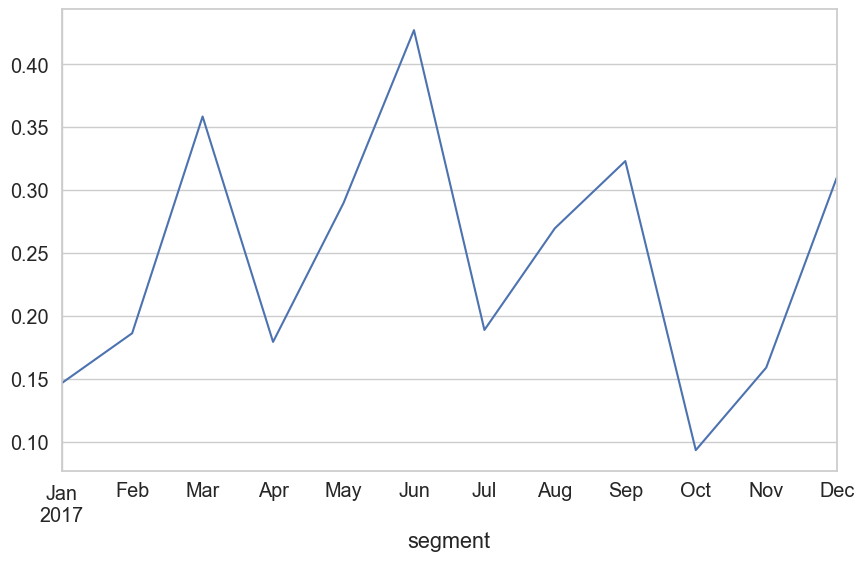

In [109]:
retention_df[3].plot();

Выводы:
- Общая динамика retention с течением времени в заметной степени не наблюдается
- В целом retention довольно низкий (=> пользователи очень редко возвращаются, что было заметно и ранее)

_Топ retention по 3му месяцу_

In [110]:
retention_df[3].sort_values(ascending=False)

segment
2017-06    0.427070
2017-03    0.358423
2017-09    0.322981
2017-12    0.309654
2017-05    0.289603
2017-08    0.269542
2017-07    0.188730
2017-02    0.186104
2017-04    0.179211
2017-11    0.158799
2017-01    0.146413
2017-10    0.093153
Freq: M, Name: 3, dtype: float64

#### Ответ: когорта (за 2017г.) с самым высоким retention на 3й месяц - пользователи, осуществившие первую покупку в июне 2017

--------------------------

### 6) Качественно оценить аудиторию. Построить RFM-сегментацию пользователей.
Метрики кластеризации:
- R - время от последней покупки пользователя до текущей даты,
- F - суммарное количество покупок у пользователя за всё время, 
- M - сумма покупок за всё время.

Подробно описать процесс создания кластеров\
Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров

Единица покупки - заказ


ДФ с покупками и пользователями

In [111]:
customers_orders_df = pd.merge(
    left=customers_df[['customer_id', 'customer_unique_id']],
    right=orders_df[['customer_id', 'order_id', 'order_status', 'order_approved_at']],
    on='customer_id'
)
customers_orders_df.head(3)

,customer_id,customer_unique_id,order_id,order_status,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10


In [112]:
customers_orders_sx_df.columns

Index(['customer_id', 'customer_unique_id', 'order_id', 'order_status',
       'order_approved_at', 'order_approved_at_month'],
      dtype='object')

Пользователи, совершившие успешную покупку (+ с известной датой покупки)

In [113]:
customers_orders_sx_df = (
    customers_orders_df
    .query('order_status == "delivered" and order_approved_at != "NaT"')
    )[['customer_unique_id', 'order_id', 'order_approved_at']]
customers_orders_sx_df.head(3)

,customer_unique_id,order_id,order_approved_at
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10


Имеющийся временной диапазон

In [114]:
min_month = customers_orders_sx_df.order_approved_at.min()
max_month = customers_orders_sx_df.order_approved_at.max()
print((min_month, max_month))

(Timestamp('2016-09-15 12:16:38'), Timestamp('2018-08-29 15:10:26'))


#### Допущения для проведения RFM-сегментации
- Предполагается, что данные на момент исследования актуальны, за текущую дату принимается следующий день после последнего заказа
- Временной период для анализа выбран стандартный (1 год)

*При этом изначальная применимость RFM-сегментации вызывает сомнения - в силу низкой регулярности покупок пользователями

Предполагаемая дата исследования

In [115]:
NOW = customers_orders_sx_df['order_approved_at'].max() + pd.Timedelta(days=1)
NOW

Timestamp('2018-08-30 15:10:26')

Временной период исследования

In [116]:
period = 365 * 1
period = pd.Timedelta(days=round(period))
period

Timedelta('365 days 00:00:00')

_Фильтрация данных по заданному временному отрезку_

In [117]:
customers_orders_sx_df = (
    customers_orders_sx_df[customers_orders_sx_df.order_approved_at >= (NOW - period)]
)
customers_orders_sx_df.head(3)

,customer_unique_id,order_id,order_approved_at
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19


Проверка. Новый временной диапазон

In [118]:
min_month = customers_orders_sx_df.order_approved_at.min()
max_month = customers_orders_sx_df.order_approved_at.max()
print((min_month, max_month))

(Timestamp('2017-08-30 15:15:25'), Timestamp('2018-08-29 15:10:26'))


In [119]:
customers_orders_sx_df.shape

(74498, 3)

_Детализация заказа по товарным позициям_

In [120]:
items_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [121]:
coi_sx_df = customers_orders_sx_df.merge(items_df[['order_id', 'product_id', 'price']], on='order_id', how='left')
coi_sx_df.head(3)

,customer_unique_id,order_id,order_approved_at,product_id,price
0,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,4aa6014eceb682077f9dc4bffebc05b0,289.00
1,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,bd07b66896d6f1494f5b86251848ced7,139.94
2,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,a5647c44af977b148e0a3a4751a09e2e,149.94


In [122]:
coi_sx_df.shape

(85262, 5)

In [123]:
coi_sx_df.price.isna().sum()

0

=> для всех заказов нашлось соответствие по товарным позициям

_Расчёт стоимости заказа из предположения, что каждый товар продаётся в единичном экземпляре_

In [124]:
# Агрегационное выражение
agg_exp = {
    'price': 'sum',  # Сумма по товарным позициям для заказа
    'order_approved_at': 'max'  # Выбор единственной даты (в любом случае для товарных позиций фиксированного заказа даты совпадают)
}
# Непосредственно расчёт
coi_sx_df = coi_sx_df.groupby(['customer_unique_id', 'order_id'], as_index=False).agg(agg_exp)
coi_sx_df.head(3)

,customer_unique_id,order_id,price,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,129.90,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,18.90,2018-05-07 18:25:44
2,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,25.99,2017-10-12 20:49:17


In [125]:
coi_sx_df.shape

(74498, 4)

Текущая дата

In [126]:
now = coi_sx_df['order_approved_at'].max() + pd.Timedelta(days=1)
now

Timestamp('2018-08-30 15:10:26')

df с колонками recency, frequency, monetary

In [127]:
rfm_df = rfm.get_rfm_values(
    df=coi_sx_df,
    unit_id='customer_unique_id',
    money='price',
    time='order_approved_at',
    now=now,
    time_horizon=365
)
rfm_df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,146,1,154.00
...,...,...,...,...
72519,fffa431dd3fcdefea4b1777d114144f2,303,1,64.99
72520,fffb09418989a0dbff854a28163e47c6,254,1,58.00
72521,fffbf87b7a1a6fa8b03f081c5f51a201,245,1,149.00
72522,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89


_Оценка rfm параметров_

In [128]:
max_score = 3  # Максимальная оценка для rmf-анализа

In [129]:
rfm_df = rfm.get_rfm_score(
    df=rfm_df,
    score_column='recency',
    score_name='r',
    max_score=max_score,
    add_score_bins=True
)

{'bins_for_scores': {'1': '[226.0, 364]',
                     '2': '[118.0, 226.0]',
                     '3': '[1, 118.0]'}}


In [130]:
rfm_df = rfm.get_rfm_score(
    df=rfm_df,
    score_column='frequency',
    score_name='f',
    max_score=max_score,
    add_score_bins=True,
    auto_max_score_adjust=True
)

AUTO ADJUSTMENT max_score=3 -> 2
{'bins_for_scores': {'1': '[1, 1.0]', '2': '[1.0, 11]'}}


In [131]:
rfm_df = rfm.get_rfm_score(
    df=rfm_df,
    score_column='monetary',
    score_name='m',
    max_score=max_score,
    add_score_bins=True,
    auto_max_score_adjust=True
)

{'bins_for_scores': {'1': '[0.85, 58.67]',
                     '2': '[58.67, 128.8]',
                     '3': '[128.8, 13440.0]'}}


In [132]:
rfm_df = rfm.get_rfm_agg(
    df=rfm_df,
    unit_id='customer_unique_id',
    use_bins=True
)

In [133]:
rfm_df

,rfm,r_bin,f_bin,m_bin,amount
0,323,"[1, 118.0]","[1.0, 11]","[128.8, 13440.0]",486
1,322,"[1, 118.0]","[1.0, 11]","[58.67, 128.8]",167
2,321,"[1, 118.0]","[1.0, 11]","[0.85, 58.67]",48
3,313,"[1, 118.0]","[1, 1.0]","[128.8, 13440.0]",7637
4,312,"[1, 118.0]","[1, 1.0]","[58.67, 128.8]",8075
5,311,"[1, 118.0]","[1, 1.0]","[0.85, 58.67]",8031
6,223,"[118.0, 226.0]","[1.0, 11]","[128.8, 13440.0]",461
7,222,"[118.0, 226.0]","[1.0, 11]","[58.67, 128.8]",153
8,221,"[118.0, 226.0]","[1.0, 11]","[0.85, 58.67]",41
9,213,"[118.0, 226.0]","[1, 1.0]","[128.8, 13440.0]",7666


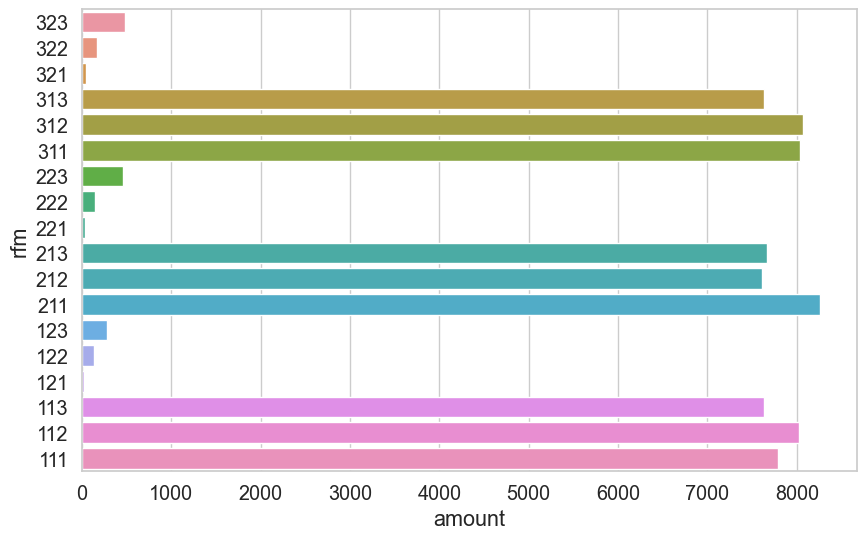

In [134]:
sns.barplot(data=rfm_df, x='amount', y='rfm');

#### Выводы
- Основной сегмент пользователей - пользователи с низкой частотой покупок
- Это и основная проблема
  - \*Это не новые пользователи, поскольку данные собраны за достаточно большой временной период, на котором почти все пользователи делали лишь одну покупку
- Возможно, это связано со спецификой магазина (специфичные товары, которые достаточно купить один раз на большой временной промежуток + розничная торговля)
- Или, возможно, это связано с неэффективным маркетингом
- Необходимо как-то увеличивать retention

_Выручка по месяцам_

In [136]:
# Столбец с месяцами
coi_sx_df['order_approved_at_month'] = coi_sx_df.order_approved_at.dt.to_period('M')

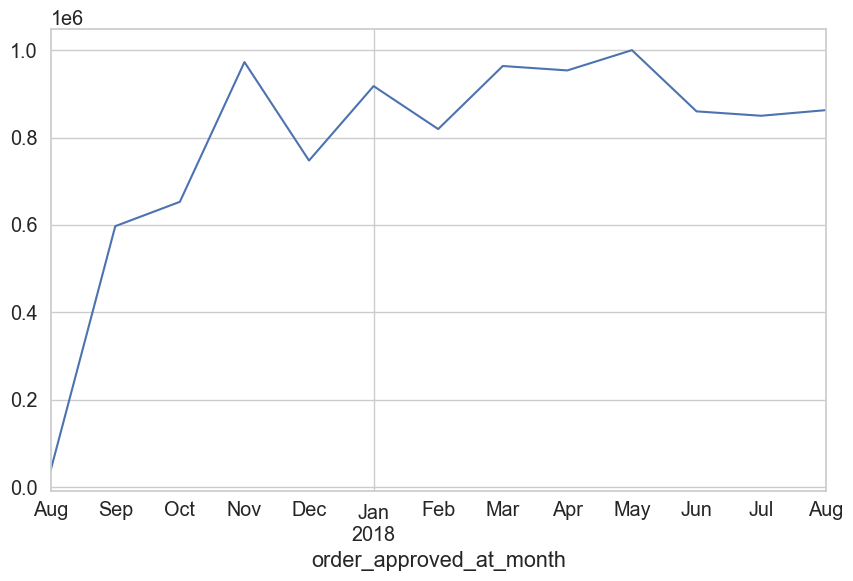

In [137]:
coi_sx_df.groupby('order_approved_at_month').price.sum().plot();

По выручке бизнес стабилен (несмотря на низкий retention)

_Расшифровка сегментов пользователей_

In [142]:
segment_map = {
    r'111':         'худшие',
    r'11[2-3]':     'не поняли ценность продукта',
    r'1[2-3][1-3]': 'нужно вернуть',
    r'21[1-3]':     'не поняли ценность продукта (есть шанс?)',
    r'2[2][1-3]':   'хорошие (напомнить/стимулировать?)',
    r'31[1-3]':     'новички',
    r'32[1-2]':     'хорошие (увеличить средний чек?)',
    r'323':         'лучшие'
    
}
rfm_df.assign(segment=rfm_df.rfm.replace(segment_map, regex=True))

,rfm,r_bin,f_bin,m_bin,amount,segment
0,323,"[1, 118.0]","[1.0, 11]","[128.8, 13440.0]",486,лучшие
1,322,"[1, 118.0]","[1.0, 11]","[58.67, 128.8]",167,хорошие (увеличить средний чек?)
2,321,"[1, 118.0]","[1.0, 11]","[0.85, 58.67]",48,хорошие (увеличить средний чек?)
3,313,"[1, 118.0]","[1, 1.0]","[128.8, 13440.0]",7637,новички
4,312,"[1, 118.0]","[1, 1.0]","[58.67, 128.8]",8075,новички
5,311,"[1, 118.0]","[1, 1.0]","[0.85, 58.67]",8031,новички
6,223,"[118.0, 226.0]","[1.0, 11]","[128.8, 13440.0]",461,хорошие (напомнить/стимулировать?)
7,222,"[118.0, 226.0]","[1.0, 11]","[58.67, 128.8]",153,хорошие (напомнить/стимулировать?)
8,221,"[118.0, 226.0]","[1.0, 11]","[0.85, 58.67]",41,хорошие (напомнить/стимулировать?)
9,213,"[118.0, 226.0]","[1, 1.0]","[128.8, 13440.0]",7666,не поняли ценность продукта (есть шанс?)


Inspired by: KCM6